In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyreadr
import yaml
from os.path import join
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

%matplotlib inline

In [3]:
with open(join('..', '..', 'config.yml')) as f:
    config = yaml.safe_load(f)
    
pwd = config['pwd']
dpath = config['storage']

In [4]:
FIG_SAVE_DIR = join(pwd, 'figures')
RESULT_SAVE_DIR = join(pwd, 'results')

In [129]:
cases_df = pd.read_csv(join(pwd, 'util_datasets', 'nyc-daily-cases.csv'))
cases_df = cases_df.groupby('Date').sum()[['Cases_New']]
cases_df.index = pd.to_datetime(cases_df.index)
cases_df.sort_index(inplace=True)

In [54]:
ridership_df = pd.read_csv(join(pwd, 'util_datasets', 'mta_ridership.csv'))

col_names = {
    'Subways: Total Estimated Ridership': 'subway_est',
    'Subways: % Change From Prior Year Equivalent Day': 'subway_chg',
    'Buses: Total Estimated Ridership': 'buses_est',
    'Buses: % Change From Prior Year Equivalent Day': 'buses_chg',
    'LIRR: Total Estimated Ridership': 'lirr_est',
    'LIRR: % Change From 2019 Monthly Weekday/Saturday/Sunday Average': 'lirr_chg',
    'Metro-North: Total Estimated Ridership': 'metro_est',
    'Metro-North: % Change From 2019 Monthly Weekday/Saturday/Sunday Average': 'metro_chg',
    'Access-A-Ride: Total Scheduled Trips': 'Aride_est',
    'Access-A-Ride: % Change From 2019 Monthly Weekday/Saturday/Sunday Average': 'Aride_chg',
    'Bridges and Tunnels: Total Traffic': 'bridge_est',
    'Bridges and Tunnels: % Change From Prior Year Equivalent Day': 'bridge_chg'
}

ridership_df = ridership_df.rename(col_names, axis=1)
ridership_df['Date'] = pd.to_datetime(ridership_df['Date'])
obj_cols = [c for c in ridership_df.columns if c.endswith('_chg')]

for col in obj_cols:
    ridership_df[col] = ridership_df[col].str.replace('%', '')
    ridership_df[col] = pd.to_numeric(ridership_df[col]) / 100
    
trans_attrs = set([i.split('_')[0] for i in col_names.values()])

for t in trans_attrs:
    ridership_df[f'{t}_prev_year'] = ridership_df[f'{t}_est'] / (ridership_df[f'{t}_chg'] + 1)
  
ridership_df['overall_ridership'] = ridership_df[[f'{t}_est' for t in trans_attrs]].sum(axis=1)
ridership_df['overall_ridership_prev_year'] = ridership_df[[f'{t}_prev_year' for t in trans_attrs]].sum(axis=1)

ridership_df.tail()

,Date,subway_est,subway_chg,buses_est,buses_chg,lirr_est,lirr_chg,metro_est,metro_chg,Aride_est,...,bridge_est,bridge_chg,subway_prev_year,Aride_prev_year,lirr_prev_year,bridge_prev_year,metro_prev_year,buses_prev_year,overall_ridership,overall_ridership_prev_year
374,2020-03-05,5513656,-0.044,2244500,-0.01,NaN,NaN,NaN,NaN,33211,...,929298.0375,-0.009,5.767423e+06,29732.318711,NaN,937737.676589,NaN,2.267172e+06,8.720665e+06,9.002064e+06
375,2020-03-04,5515945,-0.032,2177200,-0.03,NaN,NaN,NaN,NaN,34304,...,905558.4000,-0.001,5.698290e+06,29726.169844,NaN,906464.864865,NaN,2.244536e+06,8.633007e+06,8.879017e+06
376,2020-03-03,5498556,-0.039,2228600,-0.03,NaN,NaN,NaN,NaN,32768,...,882175.1750,-0.017,5.721702e+06,29735.027223,NaN,897431.510682,NaN,2.297526e+06,8.642099e+06,8.946395e+06
377,2020-03-02,5347055,0.239,2209100,0.40,NaN,NaN,NaN,NaN,30340,...,874619.9500,0.274,4.315621e+06,29745.098039,NaN,686514.874411,NaN,1.577929e+06,8.461115e+06,6.609810e+06
378,2020-03-01,2214601,-0.013,984900,0.01,NaN,NaN,NaN,NaN,19922,...,786960.6125,0.078,2.243770e+06,17614.500442,NaN,730019.121058,NaN,9.751485e+05,4.006384e+06,3.966552e+06


In [66]:
weekly_ridership = ridership_df.groupby([pd.Grouper(key='Date', freq='W-MON')]).sum().reset_index().sort_values('Date')
weekly_ridership.Date = weekly_ridership.Date - pd.to_timedelta(7, unit='d')
weekly_ridership.set_index('Date', inplace=True)

In [139]:
for t in trans_attrs:
    weekly_ridership[f'{t}_chg'] = (weekly_ridership[f'{t}_est'] - weekly_ridership[f'{t}_prev_year']) / weekly_ridership[f'{t}_prev_year'] * 100

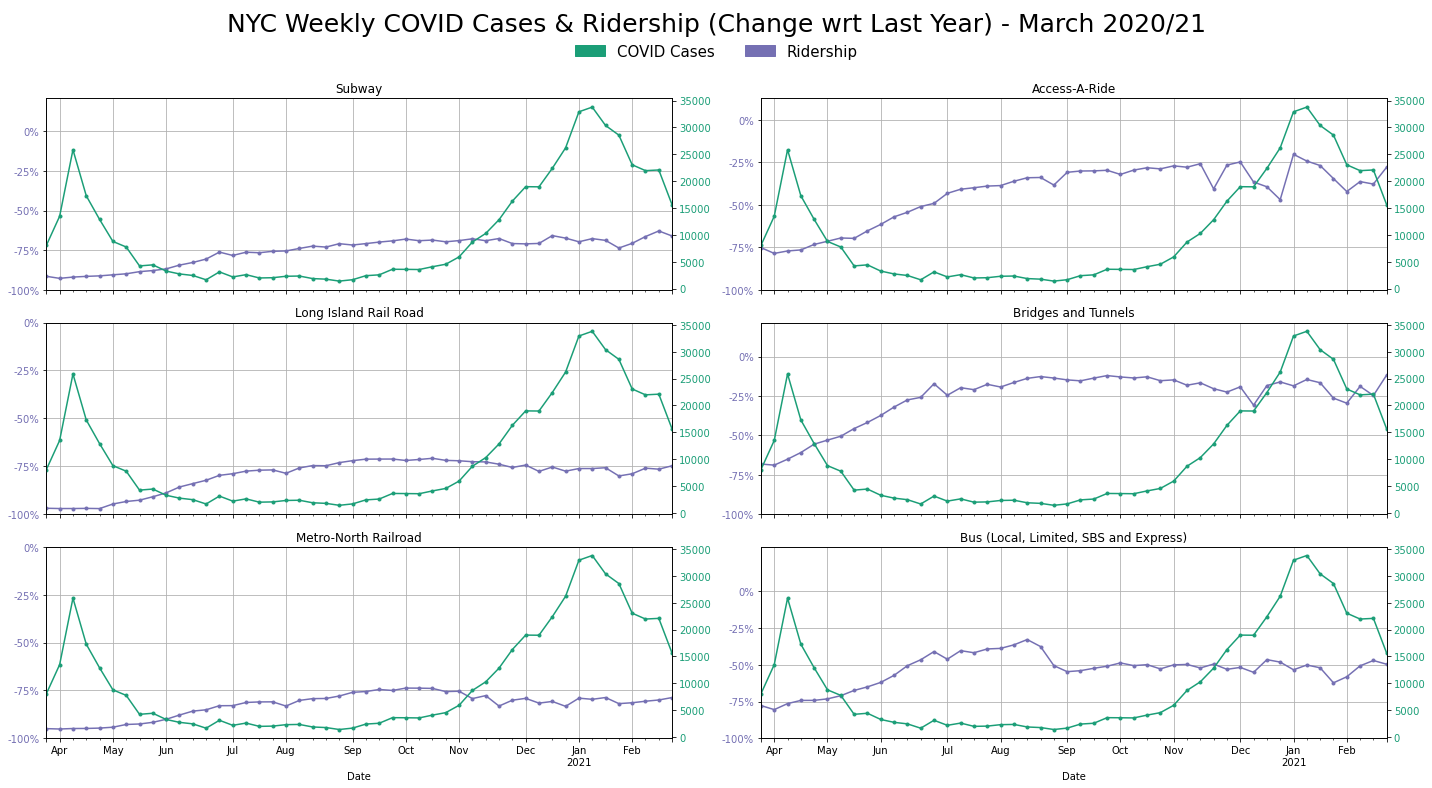

In [172]:
cases_color = '#1b9e77'
ridership_color = '#7570b3'

titles = {
    'Aride': 'Access-A-Ride',
    'bridge': 'Bridges and Tunnels',
    'buses': 'Bus (Local, Limited, SBS and Express)',
    'lirr': 'Long Island Rail Road',
    'metro': 'Metro-North Railroad',
    'subway': 'Subway'
}

fig, axl = plt.subplots(3, 2, figsize=(20, 10))

for ta, ax in zip(trans_attrs, axl.flatten()):

    weekly_ridership[f'{ta}_chg'].plot(ax=ax, label='Trans', color=ridership_color, marker='o', markersize=3)
    ax.grid()
    ax.tick_params(axis='y', labelcolor=ridership_color)
    ax.set_title(titles[ta])
    xlocs = np.linspace(0, -100, 5)
    ax.set_yticks(xlocs)
    ax.set_yticklabels([f'{i:.0f}%' for i in xlocs])

    axr = ax.twinx()
    cases_df['Cases_New'].plot(ax=axr, color=cases_color, marker='o', markersize=3)
    axr.tick_params(axis='y', labelcolor=cases_color)
    
    cases_patch = mpatches.Patch(color=cases_color)
    ridership_patch = mpatches.Patch(color=ridership_color)

fig.legend([cases_patch, ridership_patch],
                   ['COVID Cases', 
                    'Ridership'],
                   loc="center",
                   ncol=2,
                   bbox_to_anchor=(0.5, 1.05), 
                   fontsize=15,
                   title_fontsize=25,
                   title="NYC Weekly COVID Cases & Ridership (Change wrt Last Year) - March 2020/21", 
                   edgecolor="white")

fig.tight_layout()
fig.savefig(join(FIG_SAVE_DIR, "nyc-covid-cases-ridership-perc-change.png"), bbox_inches="tight")